In [0]:
#####################################################################################
##########################      IMPORTING THE LIBRARIES    ##########################
#####################################################################################
import pandas as pd
import numpy as np

# LIBRARIES FOR THE RNN CLASSIFIER
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer

# FOR THE GOOGLE WORD TO VECTOR WEIGHTS
import gensim

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score

# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

In [0]:
# IMPORTING THE DATASET
train_data=pd.read_csv("./TrainingData.csv")
test_data=pd.read_csv("./SubtaskA_Trial_Test_Labeled.csv")
valid_data=pd.read_csv("./SubtaskA_EvaluationData_labeled.csv")

In [0]:
#####################################################################################
##########################        CLEANING THE DATA        ##########################
#####################################################################################

# FUNCTION TO CLEAN A GIVEN DATASET 
def cleanData(data):
  
  import nltk
  from nltk.corpus import stopwords
  from nltk.stem.porter import PorterStemmer
  nltk.download('stopwords')
  
  # CACHING THE STOP WORDS HELPS IN FASTENING 
  # THE REMOVAL OF THE STOP WORDS
  cachedStopWords = stopwords.words("english")
  
  # REMOVING THE SPECIAL CHARACTERS
  print('Removed Special Characters')
  data=data.str.replace("[^a-zA-Z#]"," ")
  print(data.head())

  # TOKENIZING THE DATASET SENTENCES
  tokenized=data.apply(lambda x: x.split())

  # REMOVING THE STOP WORDS
  print('Removing Stop Words')
  # BY REMOVING THE STOP WORDS FROM NLTK, BUT IT MIGHT
  # REMOVES OTHER IMPORTANT WORDS SUCH AS 'CAN' WHICH MIGHT BE
  # USEFUL FOR SUGGESSTION MINING
  # tokenized = tokenized.apply(
  #   lambda sentence: [word for word in sentence if word not in cachedStopWords]
  # )
  # REMOVING SHORTWORDS (ALMOST ALL ARE STOPWORDS) 
  tokenized = tokenized.apply(
    lambda sentence: [word for word in sentence if len(word)>2 ]
  )
  print(tokenized.head())

  # LOWERING THE SENTENCE CASE SO THAT 'Which' and 'Which' BECOMES THE SAME
  print('Normalizing Sentence Case')
  tokenized = tokenized.apply(
    lambda sentence: [word.lower() for word in sentence]
  )
  print(tokenized.head())

  # CHANGING DIFFERNT WORD FORMS TO ONE
  print('After Stemming')
  stemmer =  PorterStemmer()
  tokenized = tokenized.apply(lambda x: [stemmer.stem(i) for i in x] )
  print(tokenized.head())

  # DETOKENIZING THE TOKENS BACK TO THE SENTENCES
  detokenized= tokenized.apply(lambda x: ' '.join(x))
  return detokenized

In [5]:
# CLEANING THE TRAINING DATA
x_train = cleanData(train_data['sentence'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removed Special Characters
0                   Please enable removing language code from the Dev Center  language history  For example if you ever selected  ru  and  ru ru  laguages and you published this xap to the Store then it causes Tile localization to show the en us default  tile localization which is bad  
1     Note  in your  csproj file  there is a SupportedCultures entry like this   SupportedCultures de DE ru ru RU   SupportedCultures  When I removed the  ru  language code and published my new xap version  the old xap version still remains in the Store with  Replaced and unpublished   
2                                                                                                                                                                                   Wich means the new version not fully replaced the old version and this causes me very serious prob

In [6]:
# CLEANING THE TESTING DATA
x_test = cleanData(test_data['sentence'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removed Special Characters
0                                                                                                                                       I m not asking Microsoft to Gives permission like Android so any app can take my data  but don t keep it restricted like iPhone 
1                                                                                                                                                                                                                                  somewhere between Android and iPhone 
2                                                                                                                                                                                            And in the Windows Store you can flag the App  Requires Trust  for example 
3    Many thanks Sameh Hi  As we know  there is a lot of li

In [7]:
# CLEANING THE VALIDATION DATA
x_valid = cleanData(valid_data['sentence'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removed Special Characters
0                                                                                                                                                        This would enable live traffic aware apps 
1                                                                                                Please try other formatting like bold italics shadow to distinguish titles subtitles from content 
2    Since computers were invented to save time I suggest we be allowed to upload them all in one zip file   using numbering for the file names and the portal could place them in the right order 
3                                                                                                                                               Allow rearranging if the user wants to change them 
4                                                                     

In [8]:
y_train=train_data['label']
y_valid=valid_data['label']
y_test=test_data['label']

# MERGING THE TRAINING AND VALIDATION DATA
# TO HAVE EMBEDDING MATRIX WITH ALL WORDS
x_train=x_train.append(x_valid)
y_train=y_train.append(y_valid)

print('train', x_train.shape,y_train.shape)
print('test', x_test.shape,y_test.shape)

train (9333,) (9333,)
test (592,) (592,)


In [10]:
# PEEKING INTO THE TEST DATA
print(x_test.head())
test_data.head()

0                                                                                     not ask microsoft give permiss like android ani app can take data but don keep restrict like iphon
1                                                                                                                                                     somewher between android and iphon
2                                                                                                                      and the window store you can flag the app requir trust for exampl
3    mani thank sameh know there lot limit due the high secur the itself which veri good but some time need allow some app extra work app which trust hotmail app facebook app skype app
4                                                                              the idea that can develop regular app and request our permiss the manifest the app can ask for trust more
Name: sentence, dtype: object


,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",0
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",1


In [0]:
#####################################################################################
########################## BUILDING THE EMBEDDING MATRIX   ##########################
#####################################################################################

In [11]:
# BUILDING VOCABULARY FROM THE SENTENCES
# THIS WILL HELP IN GETTING THE INPUT SEQUENCES FOR THE 
mxlen=0
tokenized=x_train.apply(lambda x: x.split())
for tokens in tokenized:
  mxlen=max(mxlen,len(tokens))
print('MAX LEN', mxlen)

MAX LEN 184


In [12]:
all_words= [ word for tokens in tokenized for word in tokens]
vocab = sorted(list(set(all_words)))
vocab_train_len=len(vocab)
print('VOCAB SIZE',len(vocab))

VOCAB SIZE 6493


In [0]:
# MAX LEN OF AN INPUT SEQUENCE
MXSEQLEN=80
# GOOGLE NEWS WORD VECTOR ENCODING SIZE
EMBEDDING_DIM = 300

In [13]:
# BUILDING TOKENIZER FROM THE TRAINING DATA
# SAME TOKENIZER WILL BE USED IN THE TESTING AND VALIDATIONS
tokenizer = Tokenizer(num_words=vocab_train_len, lower=True, char_level=False)
tokenizer.fit_on_texts(x_train.tolist())
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 6483 unique tokens.


In [16]:
# form the sequences that will be the input to the network
# padd or remove values to make sequences of equal length
train_word_index= tokenizer.word_index
train_sequence = tokenizer.texts_to_sequences(x_train.tolist())
train_sequence = sequence.pad_sequences(train_sequence, maxlen=MXSEQLEN)
print(train_sequence)

[[   0    0    0 ...  250   34  502]
 [   0    0    0 ...  614    2 1917]
 [   0    0    0 ...   89  978   93]
 ...
 [   0    0    0 ...   89   89  904]
 [   0    0    0 ...  490   71   91]
 [   0    0    0 ...   63  210  190]]


In [17]:
# TEST SEQUENCE BUILT FROM THE SAME TRAINING VOCABULARY
test_sequence = tokenizer.texts_to_sequences(x_test.tolist())
test_sequence = sequence.pad_sequences(test_sequence, maxlen=MXSEQLEN)
print(test_sequence)

[[  0   0   0 ... 644  16 665]
 [  0   0   0 ... 152   2 665]
 [  0   0   0 ... 850   4  90]
 ...
 [  0   0   0 ... 339   4 206]
 [  0   0   0 ...   1 310 215]
 [  0   0   0 ... 193   1 415]]


In [1]:
# DOWNLOADING THE PRETRAINED GOOGLE NEWS WORD TO VECTOR REPRESENTATIONS
!wget -P /content/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz 

--2020-03-25 12:32:45--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.143.238
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.143.238|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1647046227 (1.5G), 1638437458 (1.5G) remaining [application/x-gzip]
Saving to: ‘/content/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  76.0MB/s    in 24s     

2020-03-25 12:33:09 (65.1 MB/s) - ‘/content/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

gzip: /content/GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? y


In [18]:
# LOADING WORD TO VECTOR
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
# BUILDING THE EMBEDDING WEIGHT MATRIX, 
# WILL ACT AS NON TRAINABLE EMBEDDING LAYER PARAMETERS FOR THE RNN MODEL
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))

for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(train_embedding_weights.shape)

(6484, 300)


In [0]:
#####################################################################################
########################## BUILDING AND TRAINING THE MODEL ##########################
#####################################################################################

def RNN(embedding_weights,num_words):
    
    # THE INPUT LAYER
    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    
    # THE EMBEDDING LAYER OF EMBEDDING_WEIGHTS     
    embedding_layer = Embedding(
        num_words,                  # VOCABULARY SIZE
        EMBEDDING_DIM,              # ONE HOT ENCODING VECTOR SIZE
        weights=[embedding_weights],# EMBEGGING WEIGHTS FROM THE GOOGLE NEW WORD VECTOR
        input_length=MXSEQLEN,      # MAX LENGTH OF A SEQUENCE
        trainable=False             # PARAMETERS WILL NOT BE TRAINED
    )
    
    # THE EMBEDDING SEQUENCES FROM THE EMBEDDING LAYER 
    embedded_sequences  =   embedding_layer(sequence_input)

    # ADDING ONE LSTM LAYER OF 256 NODES
    lstm_layer = LSTM(256)(embedded_sequences)                    
    
    # DENSE NEURON LAYER
    next_layer = Dense(128, activation='relu')(lstm_layer)        
    
    # FEW DROPOUTS FOR AVOIDING OVERFIT
    next_layer = Dropout(0.5)(next_layer)                         

    # FINAL DENSE LAYER
    preds = Dense(1, activation='sigmoid')(next_layer)  

    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [21]:
# len= train_word_index +1 FOR 0 THAT WILL BE PADDED FOR COMPLETING THE SEQUENCE LENGTH
rnn_model = RNN(train_embedding_weights, len(train_word_index)+1)  

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 300)           1945200   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (No

In [35]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 7
BATCH_SIZE = 50

history = rnn_model.fit(
    train_sequence,       # THE INPUT SEQUENCES TO THE MODEL
    y_train,              # TARGET OUTPUT
    epochs=EPOCHS,    
    validation_split=0.1, # VALIDATE AFTER SHUFFLING THE DATASET
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Train on 8399 samples, validate on 934 samples
Epoch 1/7
8399/8399 [==============================] - 137s 16ms/sample - loss: 0.1317 - acc: 0.9486 - val_loss: 0.2903 - val_acc: 0.9069
Epoch 2/7
8399/8399 [==============================] - 138s 16ms/sample - loss: 0.1018 - acc: 0.9623 - val_loss: 0.4053 - val_acc: 0.8779
Epoch 3/7
8399/8399 [==============================] - 137s 16ms/sample - loss: 0.0927 - acc: 0.9637 - val_loss: 0.3396 - val_acc: 0.9122
Epoch 4/7
8399/8399 [==============================] - 135s 16ms/sample - loss: 0.0663 - acc: 0.9750 - val_loss: 0.3938 - val_acc: 0.8951
Epoch 5/7
8399/8399 [==============================] - 135s 16ms/sample - loss: 0.0486 - acc: 0.9826 - val_loss: 0.4299 - val_acc: 0.8908
Epoch 6/7
8399/8399 [==============================] - 135s 16ms/sample - loss: 0.0592 - acc: 0.9777 - val_loss: 0.4447 - val_acc: 0.9047
Epoch 7/7
8399/8399 [==============================] - 137s 16ms/sample - loss: 0.0443 - acc: 0.9843 - val_loss: 0.4163 - val

In [0]:
#####################################################################################
########################## ANALYZING AND TWEAKING THE MODEL##########################
#####################################################################################

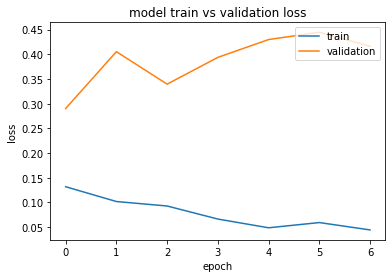

In [36]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
predict=rnn_model.predict(test_sequence)

In [41]:
# SAVING AND RELOADING THE MODEL 
from tensorflow.keras.models import load_model
rnn_model.save('/content/rnn_model87.h5')
loaded_model=load_model('rnn_model87.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
predict=[int(x+0.5) for x in predict]

In [39]:
# EVLUATING THE ACCURACY
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 82.90%
Accuracy: 87.67%


In [42]:
# ACTUAL TEST DATA------------------->
test_data['label']=y_test
test_data.head()

,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",0
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",0
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",0


In [43]:
# PREDICTIED TEST DATA------------------->
test_data['label']=predict
test_data.head()

,id,sentence,label
0,1310_1,"I'm not asking Microsoft to Gives permission like Android so any app can take my data, but don't keep it restricted like iPhone.",0
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App [Requires Trust] for example.,1
3,1313_2,"Many thanks Sameh Hi, As we know, there is a lot of limitations is WP8 OS due the high security in the OS itself which is very good, but some time we need to allow some apps to do extra works, apps which we trust i.e: hotmail app, facebook app, skype app ....",0
4,1313_3,"The idea is that we can develop a regular app and we request our permissions in the manifest, OR the app can ASK FOR TRUST_�_ more",0


In [0]:
# FINAL SUBMISSION
test_data.to_csv('/submission.csv')